In [1]:
import numpy as np
from matplotlib import pyplot as plt, animation as animation, ticker as mticker
from matplotlib.pyplot import cm
import pandas as pd
from tqdm.notebook import tqdm

from fireworks.particles import Particles
import fireworks.nbodylib.nunits as NU
import fireworks.nbodylib.potentials as fnp
import fireworks.nbodylib.dynamics as fnd
import fireworks.nbodylib.integrators as fni

%matplotlib inline

In [2]:
N = 500
initial_position = 10    #pos del 
M_G = 1e3               # mass of the galaxy

data = np.load(f'orbit/Galactic_FoR/{N}_InitialPos_{initial_position}.npy')
position = data[:, :, :3]
velocity = data[:, :, 3:6]
mass = data[:, :, 6]
# flag = data[:, :, 7]

data_Cluster_FoR = np.load(f'orbit/Cluster_FoR/{N}_InitialPos_{initial_position}.npy')
position_comFoR = data_Cluster_FoR[:, :, :3]
velocity_comFoR = data_Cluster_FoR[:, :, 3:6]

# Analysis in the FoR of the Center of Mass (rapibdly very bad performance becaus it is not the center of density)

- Radii containing a given amount of mass: usually the half-mass
radius, , i.e. the radius containing half of the total mass of the
systems is used a characteristic length of the system. Following its
evolution is possible to understand if the systems is in equilibrium (
approximately constant) or not (e.g., grows if the systems is
expanding). Combining multiple radii (e.g the one contains 10% of the
mass, the half-mass radius and the radius containing the 90% of the
mass) is possible to investigate if the system is evolving in a
homologous way or if there are decoupled regions (i.e. the inner region
is collapsing while the outer region is expanding, see e.g. Lecture 2B).
- Density profile: in order to have a more detailed view of the mass
distribution, the complete 3D density profile can be obtained as follows.
Bin the particles as a function of the spherical radius r, then sum all the
masses of the particles to obtain , finally the area of the
spherical shell is $$V_{shell} = \frac{4}{3}\pi (r_{outer}^3 - r_{inner}^3),$$ where $r_{outer}$ and $r_{inner}$
are the edges of the considered bin. Finally .
You can check how the density profile change as a function of time
during the simulation.
- Kinematics: the velocity dispersion can be used as a measure of the
kinematic status of the systems. You can replicate the above analysis
estimating the velocity dispersion within a given radius (i.e. the half-
mass radius) or estimate the radial trend of the velocity dispersion
binning the particles in spherical shells.

*Notice*: the characteristic radii and the profiles need to be estimated
considering the radius with respect to the centre of mass of the systems.
Since this can evolve during the evolution (because of some initial small
stochastic asymmetry in the initial particle distribution) remember to rescale
the position and velocities of particles by the centre of mass and centre of
mass velocity when analysis the simulation snapshots

*Notice-2*: when the mass loss starts to be significant the centre of mass
could be not centred in the density peak of the system. How could you find
the density peak of the system?

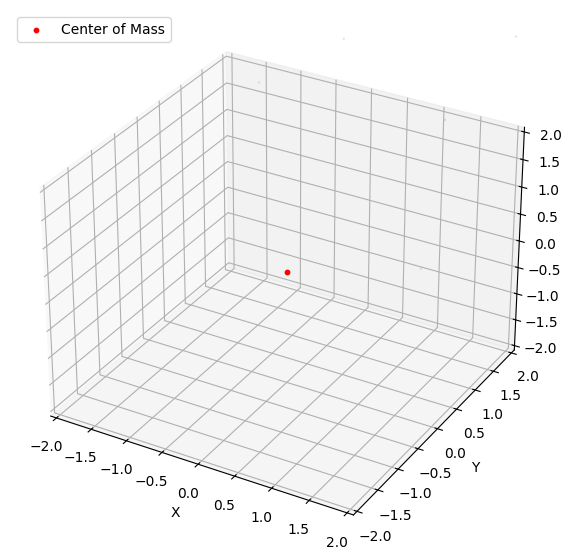

In [3]:
def plot_comFOR_scatter(positions):
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(0,0,0, s=10, c='r', label='Center of Mass')
    ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], s=1, alpha=0.1)

    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_zlim(-2, 2)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend(loc='upper left')

pos = position_comFoR[0]
plot_comFOR_scatter(pos)

## %_mass_radius
For N=5000 and initial_position=10 before T=50 it is possible to appriciate the negative heat capacity   

Text(0, 0.5, 'Radius [Henon unit]')

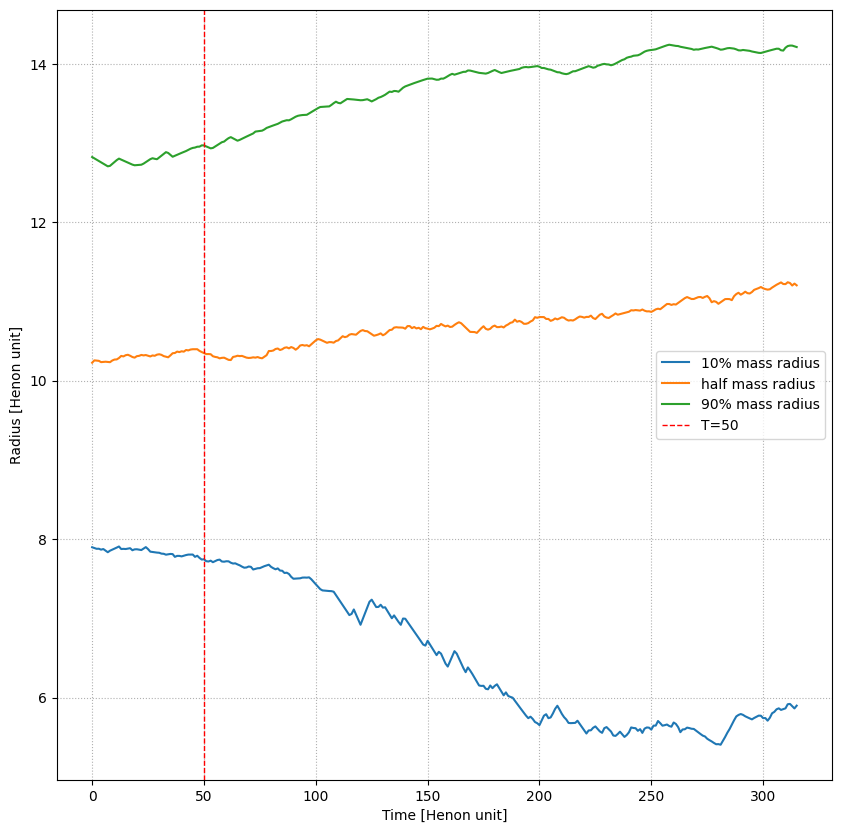

In [4]:
tenperc_mass_radius = []
half_mass_radius = []
ninethyperc_mass_radius = []

for i in range(int(len(position_comFoR))):
    current_radius = np.linalg.norm(position_comFoR[i], axis=1)
    sorted_radius = sorted(current_radius)
    tenperc_mass_radius.append(sorted_radius[int(N/10)])
    half_mass_radius.append(sorted_radius[int(N/2)])
    ninethyperc_mass_radius.append(sorted_radius[int(9*N/10)])
    
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
ax.plot(tenperc_mass_radius, label='10% mass radius')
ax.plot(half_mass_radius, label='half mass radius')
ax.plot(ninethyperc_mass_radius, label='90% mass radius')
ax.axvline(x=50, linestyle='--', c='r', linewidth=1, label='T=50')

ax.legend()
ax.grid(linestyle='dotted')
ax.set_xlabel('Time [Henon unit]')
ax.set_ylabel('Radius [Henon unit]') 
# ax.set_xlim((0, 60))
# ax.set_ylim((0, 2))

# Tidal radius and iterative calculation of the center of mass 

In [18]:
#%%timeit
N = 5000
initial_position = 10
M_G = 1e3

data = np.load(f'orbit/Galactic_FoR/{N}_InitialPos_{initial_position}.npy')
position = data[:, :, :3]
velocity = data[:, :, 3:6]
mass = data[:, :, 6]

flag_history = []
com_history = []

# Calculate distances beforehand for optimization

flag = np.ones(N, dtype=bool)

# Iterate over snapshots
for snapshot in range(len(position)):
    pos_snap, vel_snap = position[snapshot], velocity[snapshot]
    
    current_flag = np.zeros(N, dtype=bool)
    
    while not np.array_equal(flag, current_flag):
        current_flag = flag.copy()
        
        # Calculate center of mass
        pos_com_snap = np.average(pos_snap[flag], axis=0, weights=mass[snapshot][flag])
        vel_com_snap = np.average(vel_snap[flag], axis=0, weights=mass[snapshot][flag])
        
        # Calculate distances to the center of mass
        distances_to_com = np.sqrt(np.sum((pos_snap - pos_com_snap)**2, axis=1))
        
        # Calculate tidal radius
        r_t = np.linalg.norm(pos_com_snap) * (np.sum(mass[snapshot][flag]) / M_G) ** (1 / 3)
        
        # Update flag based on tidal radius
        flag = distances_to_com < 2 * r_t
    
    flag_history.append(flag)
    com_history.append(pos_com_snap)

In [19]:
#%%timeit
N = 5000
initial_position = 10
M_G = 1e3

data = np.load(f'orbit/Galactic_FoR/{N}_InitialPos_{initial_position}.npy')
position = data[:, :, :3]
velocity = data[:, :, 3:6]
mass = data[:, :, 6]

bflag_history = []
bcom_history = []
flag = np.ones(N, dtype=bool)

for snapshot in range(len(position)):
    current_flag = np.zeros(N, dtype=bool)   #this condition is used to enter the while loop
    while flag.sum() - current_flag.sum() != 0: 
        current_flag = flag.copy()
        pos_snap, vel_snap = position[snapshot], velocity[snapshot]
        pos_snap_flag, vel_snap_flag = position[snapshot][flag], velocity[snapshot][flag]
        pos_com_snap, vel_com_snap = np.mean(pos_snap_flag, axis=0), np.mean(vel_snap_flag, axis=0)
        
        pos_FoR = pos_snap - pos_com_snap
        vel_FoR = vel_snap - vel_com_snap
        
        r_t = np.linalg.norm(pos_com_snap) * (np.sum(mass[snapshot][flag])/M_G)**(1/3)
        flag = (np.linalg.norm(pos_FoR, axis=1) < 2*r_t) #in of the Cluster
        # print(snapshot, flag.sum())
    bflag_history.append(flag)
    bcom_history.append(pos_com_snap)

## Distance between true CoM and iterative CoM in tidal radius

Text(0, 0.5, '$\\Delta (r_{CoM} - r_{tidalCoM})$')

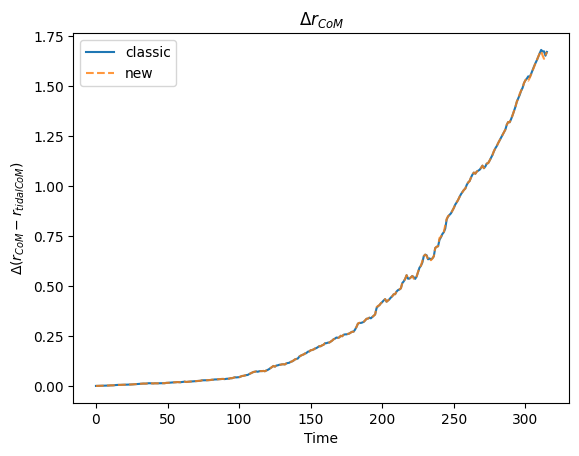

In [20]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(np.linalg.norm(np.array(bcom_history) - position[:].mean(axis=1), axis=1), label='classic')
ax.plot(np.linalg.norm(np.array(com_history) - position[:].mean(axis=1), axis=1), label='new', linestyle='--', alpha=0.8)
ax.legend()
ax.set_title(r'$\Delta r_{CoM}$')
ax.set_xlabel('Time')
ax.set_ylabel(r'$\Delta (r_{CoM} - r_{tidalCoM})$')

Text(0.5, 0, 'Z')

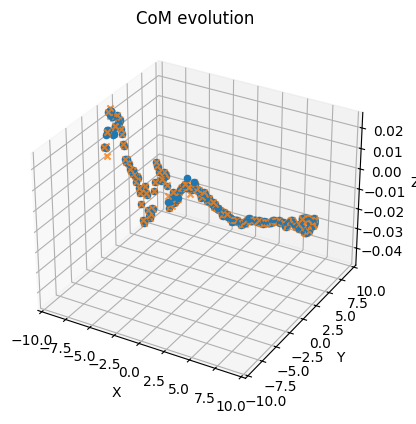

In [21]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(len(com_history)):
    ax.scatter((bcom_history)[i][0], (bcom_history)[i][1], (bcom_history)[i][2], label='classic', color='tab:blue')
    ax.scatter((com_history)[i][0], (com_history)[i][1], (com_history)[i][2], label='new', marker='x', alpha=0.8, color= 'tab:orange')

# ax.legend()
ax.set_title(r'CoM evolution')
ax.set_xlim(-initial_position, initial_position)
ax.set_ylim(-initial_position, initial_position)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

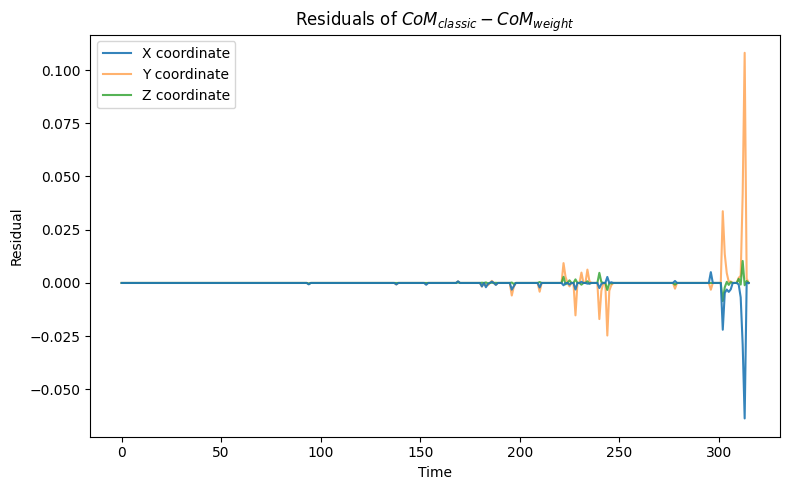

In [22]:
residuals = np.array(bcom_history) - np.array(com_history) 
time = np.arange(len(residuals))

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(time, residuals[:, 0], label='X coordinate', alpha=0.9, zorder=100)
ax.plot(time, residuals[:, 1], label='Y coordinate', alpha=0.6, zorder=-100)
ax.plot(time, residuals[:, 2], label='Z coordinate', alpha=0.8, zorder=50)

ax.set_xlabel('Time')
ax.set_ylabel('Residual')
ax.set_title(r'Residuals of $CoM_{classic} - CoM_{weight}$')
ax.legend()

plt.tight_layout()
plt.show()

## Plot the star in tidal radius, CoM tidal and true CoM

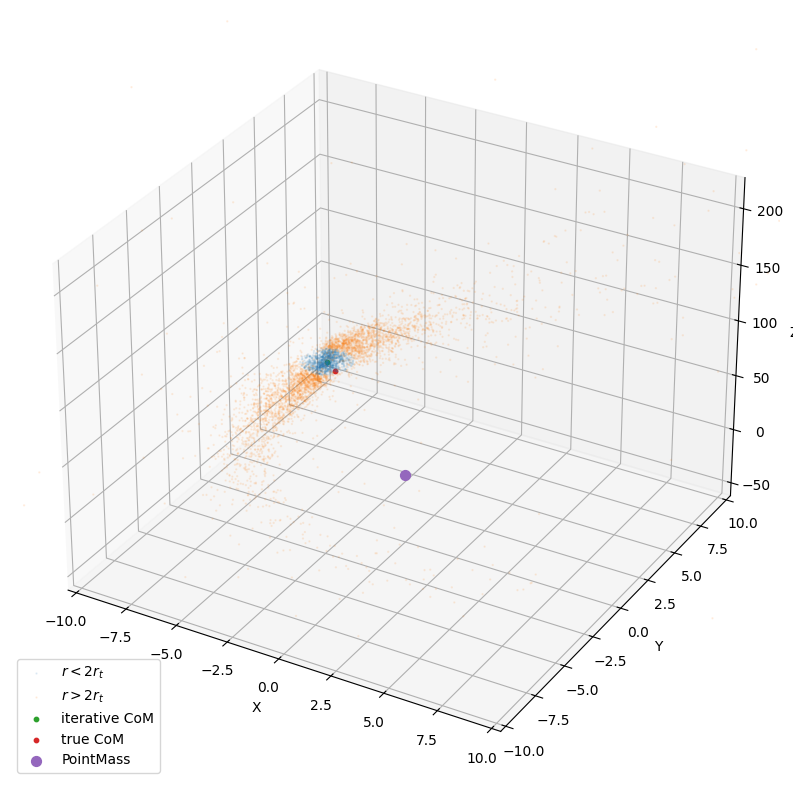

In [23]:
snapshot = 250
pos_snap = position[snapshot]
flag = flag_history[snapshot]
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(pos_snap[flag, 0], pos_snap[flag, 1], pos_snap[flag, 2], label=r'$r < 2r_{t}$', s=0.5, alpha=0.1, zorder=-1)
ax.scatter(pos_snap[~flag, 0], pos_snap[~flag, 1], pos_snap[~flag, 2], label=r'$r> 2r_{t}$', s=0.5, alpha=0.1, zorder=-1)
ax.scatter(com_history[snapshot][0], com_history[snapshot][1], com_history[snapshot][2], s=10, label='iterative CoM', zorder=1)
ax.scatter(position[snapshot].mean(axis=0)[0], position[snapshot].mean(axis=0)[1], position[snapshot].mean(axis=0)[2], s=10, label='true CoM', zorder=1)
ax.scatter(0,0,0, s=50, label='PointMass')

ax.set_xlim(-initial_position, initial_position)
ax.set_ylim(-initial_position, initial_position)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

## Analysis

### %_mass_radius
For N=5000 and initial_position=10 before T=50 it is possible to appriciate the negative heat capacity   

In [25]:
position_comFoR = np.zeros_like(position)
for i in range(len(position)):
    position_comFoR[i] = position[i] - np.array(com_history[i])

position_comFoR.shape

(316, 5000, 3)

Text(0, 0.5, 'Radius [Henon unit]')

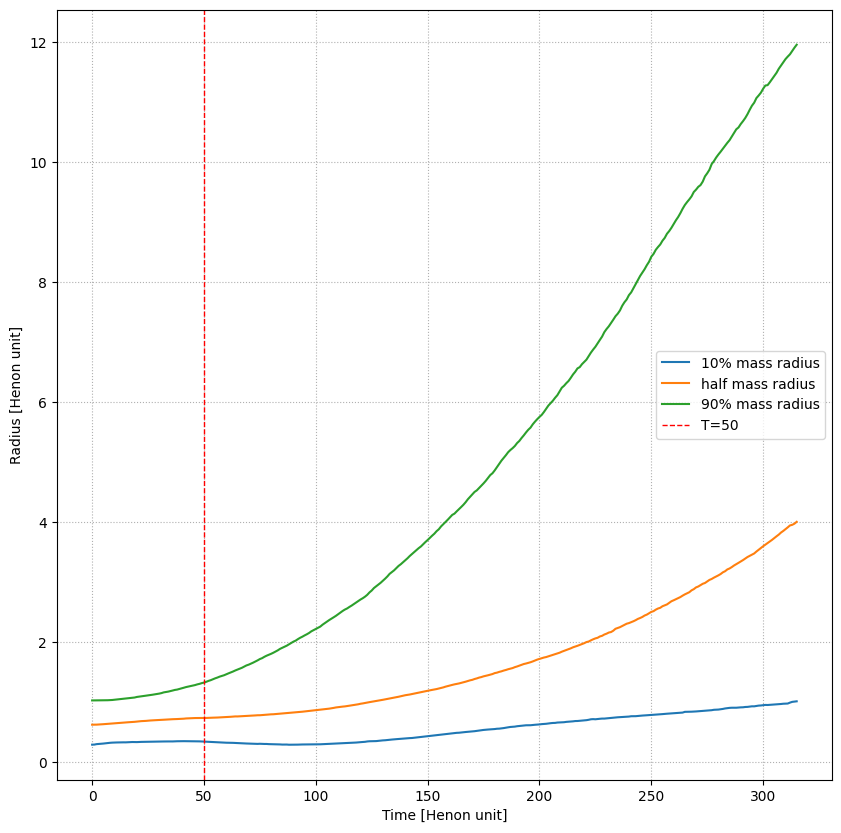

In [26]:
tenperc_mass_radius = []
half_mass_radius = []
ninethyperc_mass_radius = []


for i in range(int(len(position_comFoR))):
    current_radius = np.linalg.norm(position_comFoR[i], axis=1)
    sorted_radius = sorted(current_radius)
    tenperc_mass_radius.append(sorted_radius[int(N/10)])
    half_mass_radius.append(sorted_radius[int(N/2)])
    ninethyperc_mass_radius.append(sorted_radius[int(9*N/10)])
    
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
ax.plot(tenperc_mass_radius, label='10% mass radius')
ax.plot(half_mass_radius, label='half mass radius')
ax.plot(ninethyperc_mass_radius, label='90% mass radius')
ax.axvline(x=50, linestyle='--', c='r', linewidth=1, label='T=50')

ax.legend()
ax.grid(linestyle='dotted')
ax.set_xlabel('Time [Henon unit]')
ax.set_ylabel('Radius [Henon unit]') 
# ax.set_xlim((0, 60))
# ax.set_ylim((0, 2))

### Density profile 

Text(0.5, 1.0, 'Time: 2')

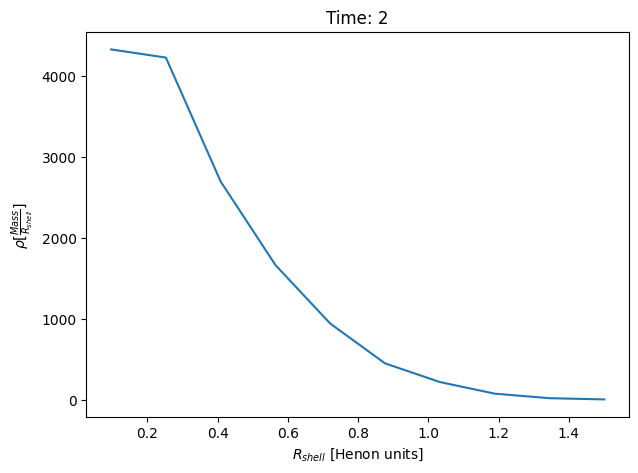

In [27]:
time = 2
flag = flag_history[time]
pos_snapshot = position_comFoR[time][flag]

radius_snapshot = np.linalg.norm(pos_snapshot, axis=1)
counts, bin_edges = np.histogram(radius_snapshot, bins=10)

Vol_shell = 4/3 *np.pi* (bin_edges[1:]**3 - bin_edges[:-1]**3)
density = counts / Vol_shell
radius_shell = 1/2 * (bin_edges[1:] + bin_edges[:-1])

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot()
ax.plot(radius_shell, density)
ax.set_xlabel(r'$R_{shell}$ [Henon units]')
ax.set_ylabel(r'$\rho [\frac{Mass}{R_{shell}}]$ ')
ax.set_title(f'Time: {time}')

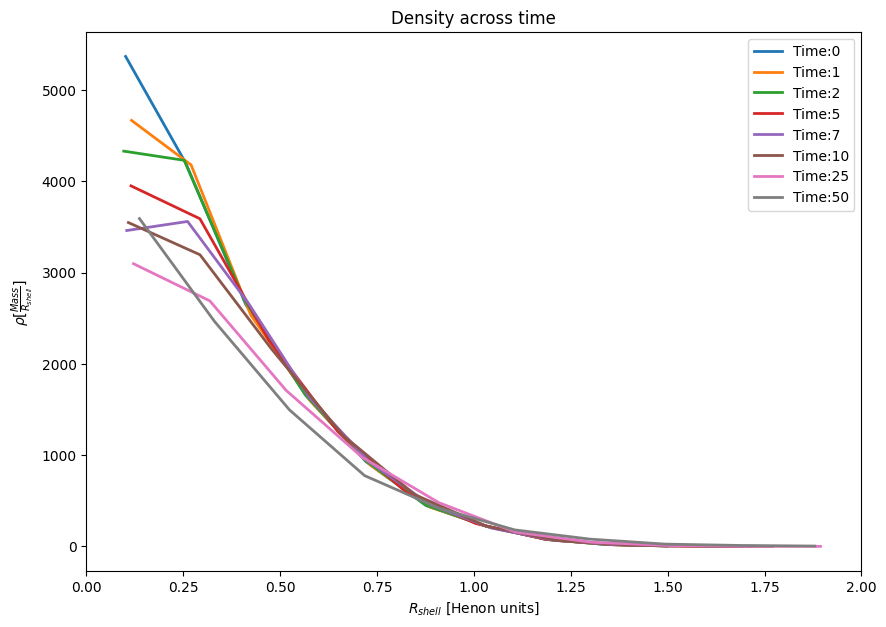

In [28]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot()
for k, time in enumerate([0, 1, 2, 5, 7, 10, 25, 50]):
    flag = flag_history[time]
    pos_snapshot = position_comFoR[time][flag]

    radius_snapshot = np.linalg.norm(pos_snapshot, axis=1)
    counts, bin_edges = np.histogram(radius_snapshot, bins=10)

    Vol_shell = 4/3 *np.pi* (bin_edges[1:]**3 - bin_edges[:-1]**3)
    density = counts / Vol_shell
    radius_shell = 1/2 * (bin_edges[1:] + bin_edges[:-1])
    
    ax.plot(radius_shell, density, label=f'Time:{time}', linewidth=2)
    ax.set_xlabel(r'$R_{shell}$ [Henon units]')
    ax.set_ylabel(r'$\rho [\frac{Mass}{R_{shell}}]$ ')
    ax.set_xlim(0, 2)
    ax.legend(loc='upper right', fontsize=10)
    ax.set_title(f'Density across time')

### Kinematics 

#### Bin the radius into shell, for each shell count the velocioty dispersion

NameError: name 'velocity_comFoR' is not defined

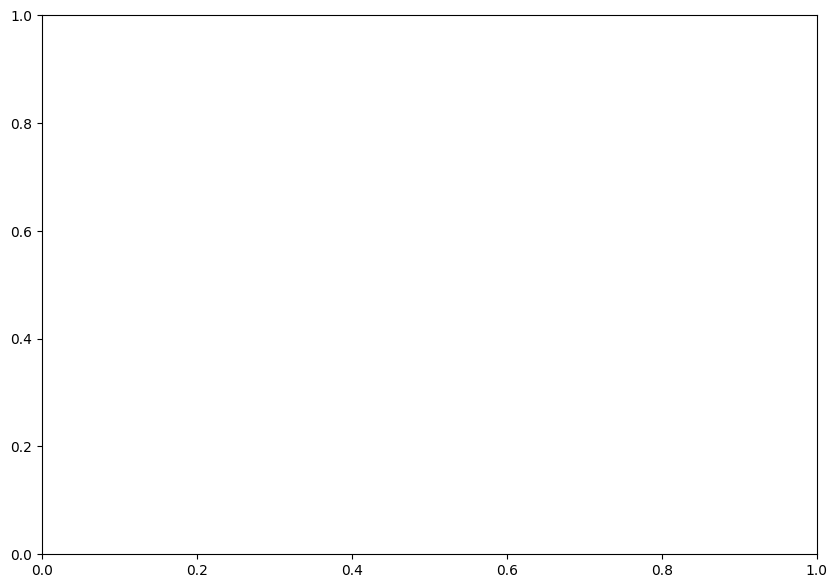

In [29]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot()
for k, time in enumerate([0, 1, 2, 5, 7, 10, 25, 50]):
    flag = flag_history[time]
    pos_snapshot = position_comFoR[time][flag]

    radius_snapshot = np.linalg.norm(pos_snapshot, axis=1)
    counts, bin_edges = np.histogram(radius_snapshot, bins=10)
    radius_shell = 1/2 * (bin_edges[1:] + bin_edges[:-1]) #needed to plot
    
    bins_index = np.digitize(radius_snapshot, bins=bin_edges) #return the index of the bin for each radius
    
    vel_snapshot = velocity_comFoR[time][flag]
    vel_modul_snapshot = np.linalg.norm(vel_snapshot, axis=1)
    
    vel_modul_snaphost_binned = [vel_modul_snapshot[bins_index==i].tolist() for i in range(1, len(bin_edges)) ] #binning the velocity as the radius
    
    velocity_dispersion = []
    for i in range(len(bin_edges)-1):
        velocity_dispersion.append(np.array(vel_modul_snaphost_binned[i]).std())
    
    ax.plot(radius_shell, np.array(velocity_dispersion)-5*k, label=f'Time: {time}', linewidth=2)
    ax.set_xlabel('Radius')
    ax.set_ylabel('Velocity dispersion in the Shell')
    ax.legend(fontsize=10)

#### Instead of shell uses sphere (cumulative of the shell)

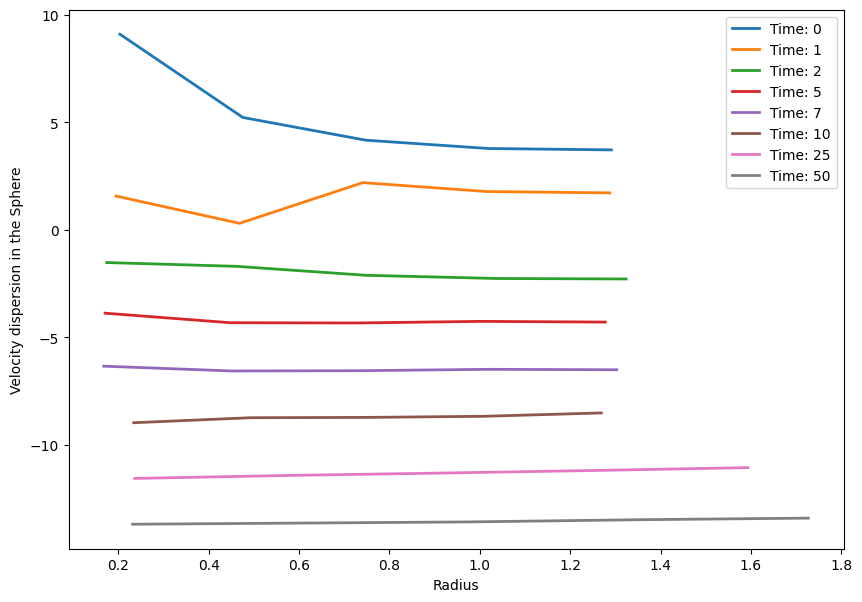

In [14]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot()
for k, time in enumerate([0, 1, 2, 5, 7, 10, 25, 50]):
    flag = flag_history[time]
    pos_snapshot = position_comFoR[time][flag]

    radius_snapshot = np.linalg.norm(pos_snapshot, axis=1)
    counts, bin_edges = np.histogram(radius_snapshot, bins=5)
    radius_shell = 1/2 * (bin_edges[1:] + bin_edges[:-1]) #needed to plot
    
    bins_index = np.digitize(radius_snapshot, bins=bin_edges) #return the index of the bin for each radius
    
    vel_snapshot = velocity_comFoR[time][flag]
    vel_modul_snapshot = np.linalg.norm(vel_snapshot, axis=1)
    
    comulative_vel_modul_snaphost_binned = [vel_modul_snapshot[bins_index<=i].tolist() for i in range(1, len(bin_edges)) ] #binning the velocity as the radius
    
    comulative_velocity_dispersion = []
    for i in range(len(bin_edges)-1):
        comulative_velocity_dispersion.append(np.array(comulative_vel_modul_snaphost_binned[i]).std())
    
    ax.plot(radius_shell, np.array(comulative_velocity_dispersion)-2*k, label=f'Time: {time}', linewidth=2)
    ax.set_xlabel('Radius')
    ax.set_ylabel('Velocity dispersion in the Sphere')
    ax.legend(fontsize=10)

# GIF

Starting Position Animation: 5000_InitialPos_10.gif 
Position Animation Saved: 5000_InitialPos_10.gif


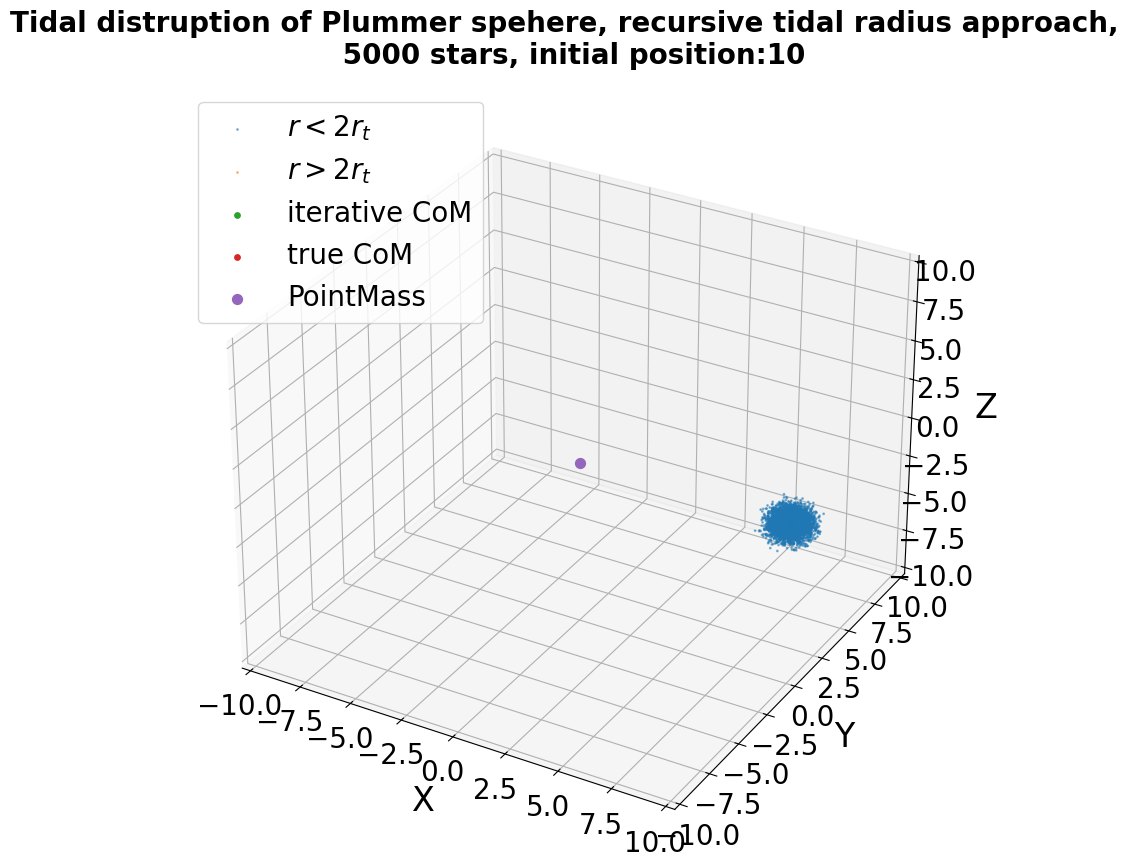

In [32]:
### downsampling
m = 2

pos_array_plot = position.copy() #the copy is useful to not overwrite pos_array (otherwise you would need to rerun the integration, we don't want that)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
plt.rcParams['font.size'] = '16'
plt.rcParams['lines.linewidth'] = '4'
plt.rcParams['axes.titlesize'] = '20'
plt.rcParams['axes.titlepad'] = '17'
plt.rcParams['axes.labelsize'] = '24'
plt.rcParams['legend.fontsize'] = '20'
plt.rcParams['axes.labelpad'] = '12'
plt.rcParams['axes.titleweight'] = '600'
plt.rcParams['axes.labelweight'] = '500'
plt.rcParams['xtick.labelsize'] = '20'
plt.rcParams['ytick.labelsize'] = '20'
plt.rcParams['xtick.major.size'] = '10'
plt.rcParams['ytick.major.size'] = '10'
plt.rcParams['ytick.minor.size'] = '4'

# Calculate the number of extra frames to add at the beginning and the end
pause_duration = 5  # pause duration in seconds start
pause_duration_end = 1  # pause duration in seconds end
frame_rate = 15  # frame rate of the animation
extra_frames = pause_duration * frame_rate
extra_frames_end = pause_duration_end * frame_rate

# Create an array of frame indices
frames = np.concatenate([
    np.full(int(extra_frames), 0),  # initial frame (pause
    np.arange(0, len(pos_array_plot[:])-1, m),  # original frames
    np.full(int(extra_frames_end), len(pos_array_plot[:])-2)  # extra frames at the end
])

snapshot = 0
pos_snap = position[snapshot]
flag = flag_history[snapshot]
ax.scatter(pos_snap[flag, 0], pos_snap[flag, 1], pos_snap[flag, 2], label=r'$r < 2r_{t}$', s=1, alpha=0.5, zorder=-1)
ax.scatter(pos_snap[~flag, 0], pos_snap[~flag, 1], pos_snap[~flag, 2], label=r'$r> 2r_{t}$', s=1, alpha=0.5, zorder=-1)
ax.scatter(com_history[snapshot][0], com_history[snapshot][1], com_history[snapshot][2], s=15, label='iterative CoM', zorder=1)
ax.scatter(position[snapshot].mean(axis=0)[0], position[snapshot].mean(axis=0)[1], position[snapshot].mean(axis=0)[2], s=15, label='true CoM', zorder=1)
ax.scatter(0,0,0, s=50, label='PointMass')

# ax.set_xlim(-initial_position, initial_position)
# ax.set_ylim(-initial_position, initial_position)
# ax.set_zlim(-initial_position, initial_position)
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# ax.legend('upper left')


def update_pos(frame): 
    ax.clear()
    
    pos_snap = position[frame]
    flag = flag_history[frame]
    ax.scatter(pos_snap[flag, 0], pos_snap[flag, 1], pos_snap[flag, 2], label=r'$r < 2r_{t}$', s=1, alpha=0.5, zorder=100)
    ax.scatter(pos_snap[~flag, 0], pos_snap[~flag, 1], pos_snap[~flag, 2], label=r'$r> 2r_{t}$', s=1, alpha=0.5, zorder=100)
    ax.scatter(com_history[frame][0], com_history[frame][1], com_history[frame][2], s=15, label='iterative CoM', zorder=-100)
    ax.scatter(position[frame].mean(axis=0)[0], position[frame].mean(axis=0)[1], position[frame].mean(axis=0)[2], s=15, label='true CoM', zorder=-100)
    ax.scatter(0,0,0, s=50, label='PointMass')
    
    ax.set_xlim(-initial_position, initial_position)
    ax.set_ylim(-initial_position, initial_position)
    ax.set_zlim(-initial_position, initial_position)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend('upper left')
    ax.set_title(f'Tidal distruption of Plummer spehere, recursive tidal radius approach, \n {N} stars, initial position:{initial_position}')
    ax.legend(loc='upper left')
    
    # fig.suptitle(f'Tidal distruption of Plummer spehere, recursive tidal radius approach', 
    #              fontsize=24, fontweight='600')

print(f"Starting Position Animation: {N}_InitialPos_{initial_position}.gif ")

gif_pos = animation.FuncAnimation(fig=fig, func=update_pos, frames=frames, interval=10)
gif_pos.save(f"./gif/Galaxy_FoR/{N}_InitialPos_{initial_position}_recursive.gif", writer="pillow")

print(f"Position Animation Saved: {N}_InitialPos_{initial_position}.gif")

Starting Position Animation: 500_InitialPos_10.gif 
Position Animation Saved: 500_InitialPos_10.gif


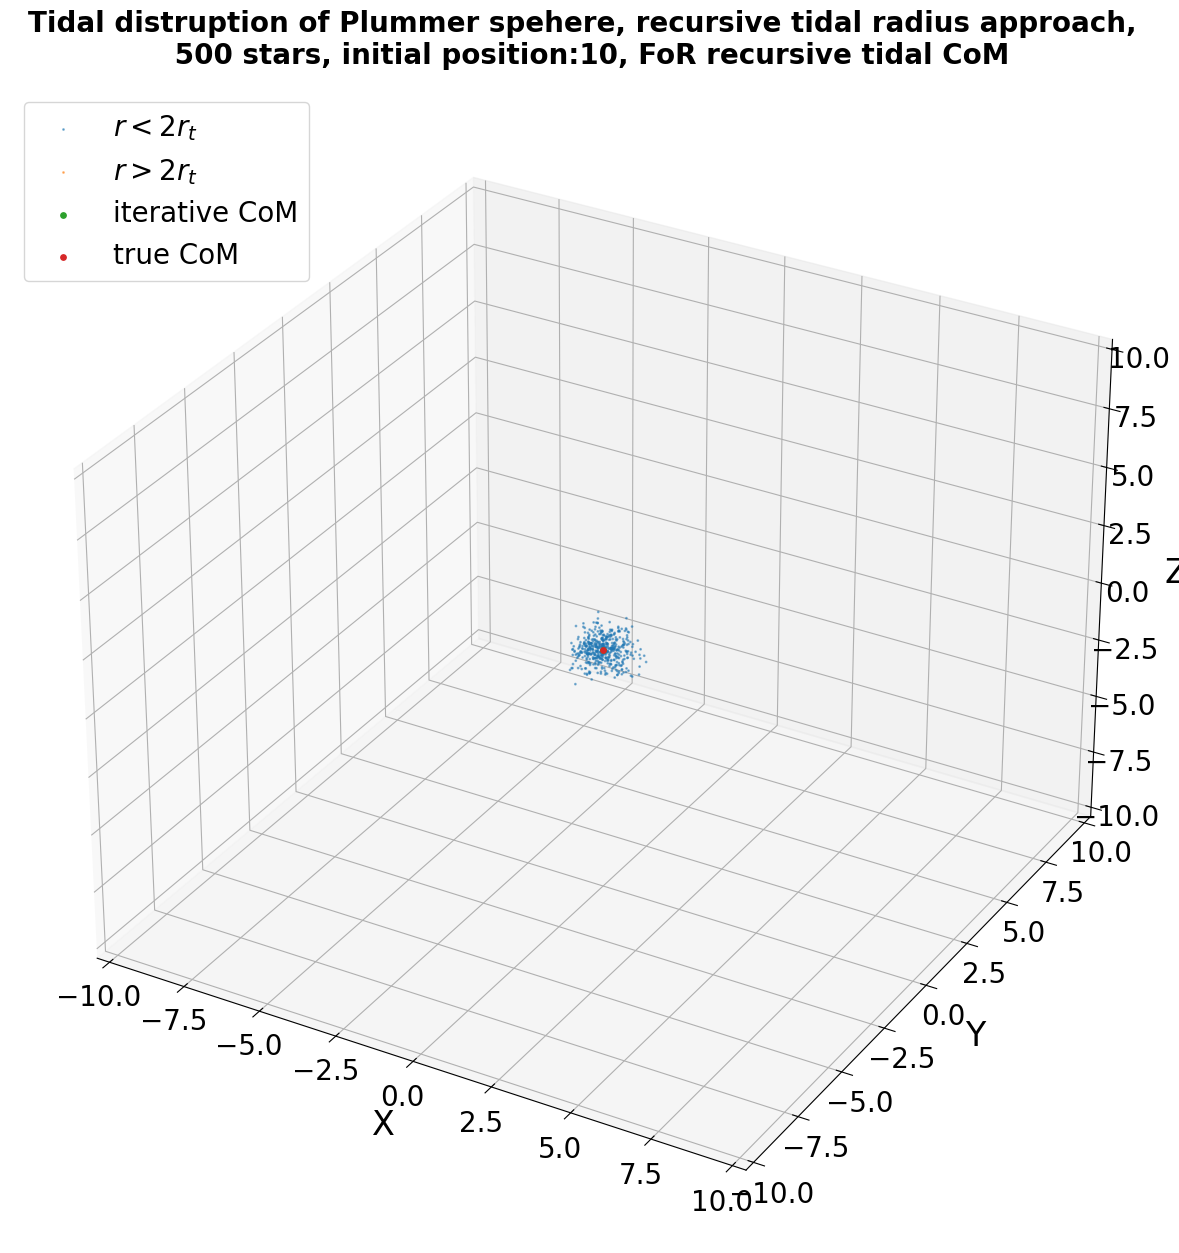

In [20]:
### downsampling
m = 2

pos_array_plot = position.copy() #the copy is useful to not overwrite pos_array (otherwise you would need to rerun the integration, we don't want that)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
plt.rcParams['font.size'] = '16'
plt.rcParams['lines.linewidth'] = '4'
plt.rcParams['axes.titlesize'] = '20'
plt.rcParams['axes.titlepad'] = '17'
plt.rcParams['axes.labelsize'] = '24'
plt.rcParams['legend.fontsize'] = '20'
plt.rcParams['axes.labelpad'] = '12'
plt.rcParams['axes.titleweight'] = '600'
plt.rcParams['axes.labelweight'] = '500'
plt.rcParams['xtick.labelsize'] = '20'
plt.rcParams['ytick.labelsize'] = '20'
plt.rcParams['xtick.major.size'] = '10'
plt.rcParams['ytick.major.size'] = '10'
plt.rcParams['ytick.minor.size'] = '4'

# Calculate the number of extra frames to add at the beginning and the end
pause_duration = 5  # pause duration in seconds start
pause_duration_end = 1  # pause duration in seconds end
frame_rate = 15  # frame rate of the animation
extra_frames = pause_duration * frame_rate
extra_frames_end = pause_duration_end * frame_rate

# Create an array of frame indices
frames = np.concatenate([
    np.full(int(extra_frames), 0),  # initial frame (pause
    np.arange(0, len(pos_array_plot[:])-1, m),  # original frames
    np.full(int(extra_frames_end), len(pos_array_plot[:])-2)  # extra frames at the end
])

snapshot = 0
pos_snap = position[snapshot] - com_history[snapshot]
flag = flag_history[snapshot]
ax.scatter(pos_snap[flag, 0], pos_snap[flag, 1], pos_snap[flag, 2], label=r'$r < 2r_{t}$', s=1, alpha=0.5, zorder=-1)
ax.scatter(pos_snap[~flag, 0], pos_snap[~flag, 1], pos_snap[~flag, 2], label=r'$r> 2r_{t}$', s=1, alpha=0.5, zorder=-1)
ax.scatter(com_history[snapshot][0] - com_history[snapshot][0], com_history[snapshot][1]-com_history[snapshot][1], com_history[snapshot][2]-com_history[snapshot][2], s=15, label='iterative CoM', zorder=1)
ax.scatter(position[snapshot].mean(axis=0)[0]- com_history[snapshot][0], position[snapshot].mean(axis=0)[1]- com_history[snapshot][1], position[snapshot].mean(axis=0)[2]- com_history[snapshot][2], s=15, label='true CoM', zorder=1)
ax.set_xlim(-initial_position, initial_position)
ax.set_ylim(-initial_position, initial_position)
ax.set_zlim(-initial_position, initial_position)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend('upper left')


def update_pos(frame): 
    ax.clear()
    
    pos_snap = position[frame] - com_history[frame]
    flag = flag_history[frame]
    ax.scatter(pos_snap[flag, 0], pos_snap[flag, 1], pos_snap[flag, 2], label=r'$r < 2r_{t}$', s=1, alpha=0.5, zorder=-1)
    ax.scatter(pos_snap[~flag, 0], pos_snap[~flag, 1], pos_snap[~flag, 2], label=r'$r> 2r_{t}$', s=1, alpha=0.5, zorder=-1)
    ax.scatter(com_history[frame][0] - com_history[frame][0], com_history[frame][1]-com_history[frame][1], com_history[frame][2]-com_history[frame][2], s=15, label='iterative CoM', zorder=1)
    ax.scatter(position[frame].mean(axis=0)[0]- com_history[frame][0], position[frame].mean(axis=0)[1]- com_history[frame][1], position[frame].mean(axis=0)[2]- com_history[frame][2], s=15, label='true CoM', zorder=1)

    
    ax.set_xlim(-initial_position, initial_position)
    ax.set_ylim(-initial_position, initial_position)
    ax.set_zlim(-initial_position, initial_position)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend('upper left')
    ax.set_title(f'Tidal distruption of Plummer spehere, recursive tidal radius approach, \n {N} stars, initial position:{initial_position}, FoR recursive tidal CoM')
    ax.legend(loc='upper left')
    
    # fig.suptitle(f'Tidal distruption of Plummer spehere, recursive tidal radius approach', 
    #              fontsize=24, fontweight='600')

print(f"Starting Position Animation: {N}_InitialPos_{initial_position}.gif ")

gif_pos = animation.FuncAnimation(fig=fig, func=update_pos, frames=frames, interval=10)
gif_pos.save(f"./gif/Cluster_FoR/{N}_InitialPos_{initial_position}_recursive.gif", writer="pillow")

print(f"Position Animation Saved: {N}_InitialPos_{initial_position}.gif")